## Notebook: Deep Learning Project - Spring2024


---

## Dataset

For this project we will use the CelebA dataset (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), which is available on Kaggle.

Description of the CelebA dataset from kaggle (https://www.kaggle.com/jessicali9530/celeba-dataset): 

### Context


### Content

#### Overall

202,599 number of face images of various celebrities
10,177 unique identities, but names of identities are not given
40 binary attribute annotations per image
5 landmark locations

#### Data Files

- <b>img_align_celeba.zip</b>: All the face images, cropped and aligned
- <b>list_eval_partition.csv</b>: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
- <b>list_bbox_celeba.csv</b>: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
- <b>list_landmarks_align_celeba.csv</b>: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
- <b>list_attr_celeba.csv</b>: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

---


### Import libraries

In [1]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print(tf.__version__)

1.11.0-rc1


## Step 1: Data Exploration

We will be using the CelebA Dataset, which includes images of 178 x 218 px. Below is an example of how the pictures looks like.

In [3]:
# set variables 
main_folder = '../input/celeba-dataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000506.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

### Load the attributes of every picture
File: list_attr_celeba.csv

In [4]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

### List of the available attribute in the CelebA dataset

40 Attributes

In [5]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


### Example of a picture in CelebA dataset
178 x 218 px

Smiling    1
Male       0
Young      1
Name: 000506.jpg, dtype: int64

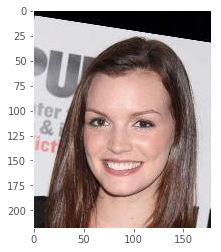

In [6]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

### Distribution of the Attribute

As specified before, this Notebook is an imagine recognition project of the Gender. There are more Female gender than Male gender in the data set. This give us some insight about the need to balance the data in next steps.

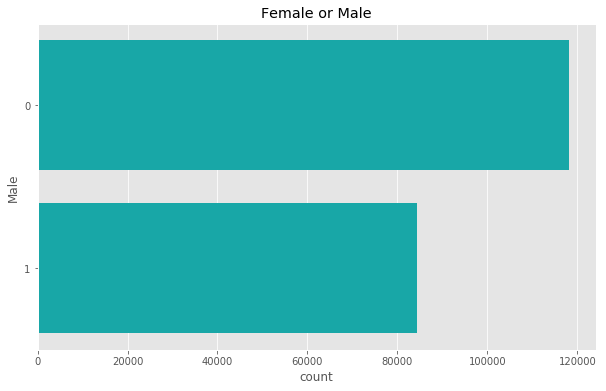

In [7]:
# Female or Male?
plt.figure(figsize=(10, 6))
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.savefig('female_or_male.png')
plt.show()

In [8]:
# Separate the dataset into males and females
df_males = df_attr[df_attr['Male'] == 1]
df_females = df_attr[df_attr['Male'] == 0]

# Calculate the mean of each attribute for males and females
male_common_attributes = df_males.mean().sort_values(ascending=False)
female_common_attributes = df_females.mean().sort_values(ascending=False)

# Print the top 5 most common attributes for each gender
print("Top 5 attributes for males:")
print(male_common_attributes.head(5))

print("\nTop 5 attributes for females:")
print(female_common_attributes.head(5))

Top 5 attributes for males:
Male                   1.000000
Young                  0.633003
No_Beard               0.605585
Mouth_Slightly_Open    0.424545
Big_Nose               0.419630
dtype: float64

Top 5 attributes for females:
No_Beard            0.998824
Young               0.874091
Wearing_Lipstick    0.805585
Attractive          0.679169
Heavy_Makeup        0.661414
dtype: float64


No_Beard               83.493996
Young                  77.361685
Attractive             51.250500
Mouth_Slightly_Open    48.342786
Smiling                48.208037
Wearing_Lipstick       47.243570
High_Cheekbones        45.503186
Male                   41.675428
Heavy_Makeup           38.692195
Wavy_Hair              31.956722
dtype: float64


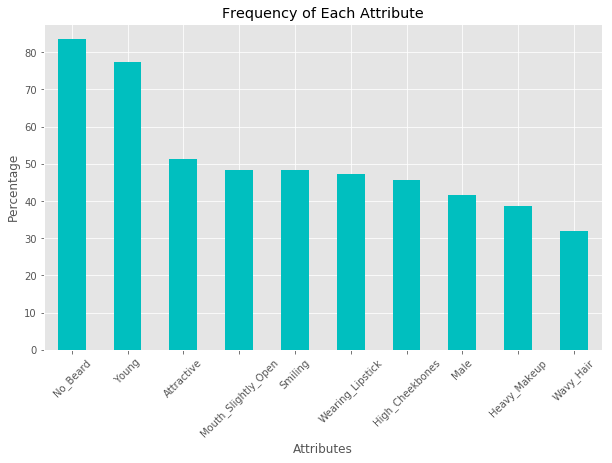

Plot saved to attribute_frequencies.png


In [9]:
import matplotlib.pyplot as plt

# Assuming df_attr is already defined
# Calculate the frequency of each attribute (top 10)
attribute_frequencies = df_attr.mean().sort_values(ascending=False).head(10) * 100  # convert to percentage

# Print the frequencies
print(attribute_frequencies)

# Plotting the frequencies
plt.figure(figsize=(10, 6))
attribute_frequencies.plot(kind='bar', color='c')
plt.title('Frequency of Each Attribute')
plt.ylabel('Percentage')
plt.xlabel('Attributes')
plt.xticks(rotation=45)
plt.grid(True)

# Save the plot to a file
plt.savefig('attribute_frequencies.png')

# Show the plot
plt.show()

print("Plot saved to attribute_frequencies.png")


## Step 2: Split Dataset into Training, Validation and Test


In [10]:
# Recomended partition
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [11]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

#### Join the partition and the attributes in the same data frame

In [12]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


### 2.1: Generate Partitions (Train, Validation, Test)

In [13]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

## Step 3: Pre-processing Images: Data Augmentation

Generates Data Augmentation for iamges.

### 3.1. Let's start with an example: Data Augmentation

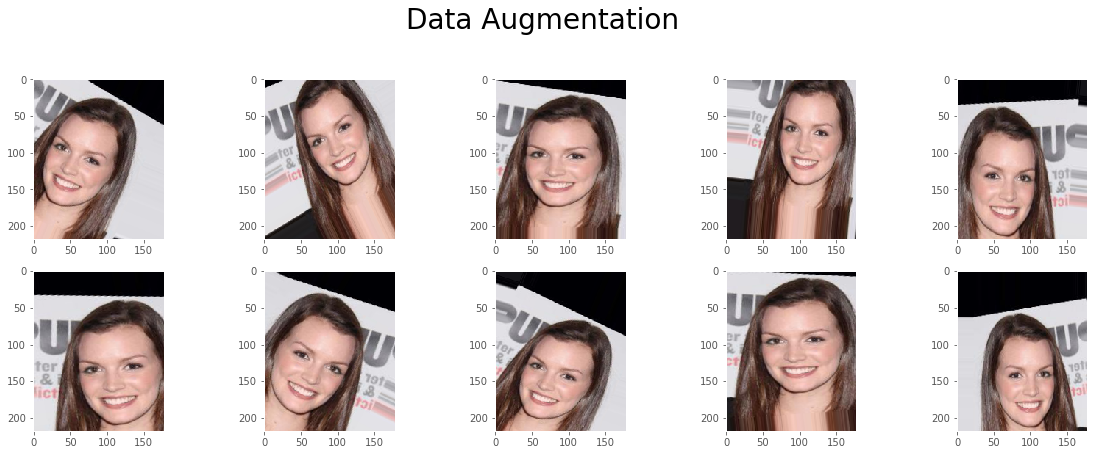

In [14]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

The result is a new set of images with modifications from the original one, that allows to the model to learn from these variations in order to take this kind of images during the learning process and predict better never seen images.

### 3.2. Build Data Generators

In [15]:
# Train data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [16]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

'''
# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)
'''

'\n# Validation - Data Preparation - Data Augmentation with generators\nvalid_datagen = ImageDataGenerator(\n  preprocessing_function=preprocess_input,\n)\n\nvalid_datagen.fit(x_valid)\n\nvalidation_generator = valid_datagen.flow(\nx_valid, y_valid,\n)\n'

With the data generator created and data for validation, we are ready to start modeling.

## Step 4: Build the Model - Gender Recognition

### 4.1. Set the Model

In [17]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


In [18]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [19]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
# Visualize the model architecture
plot_model(model_, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

### 4.2. Train Model

In [21]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

In [22]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/20
625/625 [==============================] - 105s 168ms/step - loss: 0.5343 - acc: 0.7256 - val_loss: 0.3671 - val_acc: 0.8410

Epoch 00001: val_loss improved from inf to 0.36708, saving model to weights.best.inc.male.hdf5
Epoch 2/20
625/625 [==============================] - 91s 146ms/step - loss: 0.3335 - acc: 0.8589 - val_loss: 0.2902 - val_acc: 0.8845

Epoch 00002: val_loss improved from 0.36708 to 0.29019, saving model to weights.best.inc.male.hdf5
Epoch 3/20
625/625 [==============================] - 89s 142ms/step - loss: 0.2608 - acc: 0.8943 - val_loss: 0.2811 - val_acc: 0.8910

Epoch 00003: val_loss improved from 0.29019 to 0.28109, saving model to weights.best.inc.male.hdf5
Epoch 4/20
625/625 [==============================] - 88s 141ms/step - loss: 0.2408 - acc: 0.9024 - val_loss: 0.2891 - val_acc: 0.8875

Epoch 00004: val_loss did not improve from 0.28109
Epoch 5/20
625/625 [==============================] - 88s 141ms/step - loss: 0.2113 - acc: 0.9137 - val_loss: 0

#### The best model after NUM_epech got an accuracy over the validation data of 95.75%.

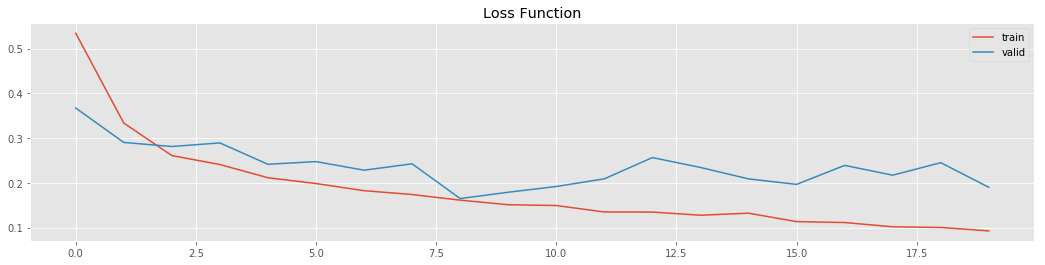

In [23]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='valid')
plt.legend()
plt.title('Loss Function')
plt.savefig('loss_function.png')  # Save the figure to a file
plt.show()

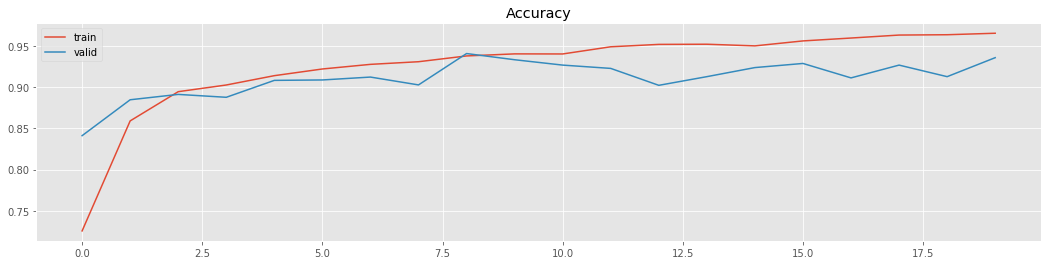

In [24]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.savefig('accuracy.png')
plt.show()

### 4.3. Model Evaluation

In [25]:
#load the best model
model_.load_weights('weights.best.inc.male.hdf5')

Model Evaluation
Test accuracy: 93.1500%
Precision: 0.9344932238188883
Recall: 0.9315
F1 Score: 0.9313818223435312
ROC AUC: 0.987335
Confusion Matrix:
 [[973  27]
 [110 890]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93      1000
           1       0.97      0.89      0.93      1000

   micro avg       0.93      0.93      0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



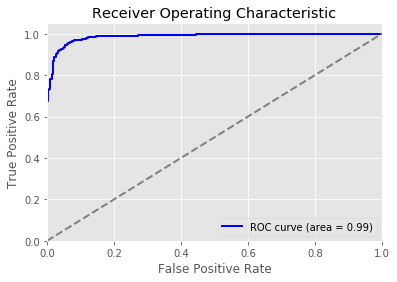

In [37]:
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score, classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Test Data
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

# Ensure the test data is in the correct shape (batch_size, height, width, channels)
x_test_array = np.array(x_test).reshape(len(x_test), x_test[0].shape[1], x_test[0].shape[2], x_test[0].shape[3])

# Generate Predictions
model_predictions = [np.argmax(pred) for pred in model_.predict(x_test_array)]

# Report Test Accuracy
test_accuracy = accuracy_score(y_test, model_predictions) * 100
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)

# Calculate Precision, Recall, and F1 Score
precision = precision_score(y_test, model_predictions, average='weighted')
recall = recall_score(y_test, model_predictions, average='weighted')
f1 = f1_score(y_test, model_predictions, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Calculate ROC Curve and AUC
y_prob = model_.predict(x_test_array)  # Use predict to get probabilities
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
roc_auc = roc_auc_score(y_test, y_prob[:, 1])

print('ROC AUC:', roc_auc)

# Print Evaluation Metrics
print('Confusion Matrix:\n', confusion_matrix(y_test, model_predictions))
print('Classification Report:\n', classification_report(y_test, model_predictions))

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')  # Save the figure to a file
plt.show()

### 5. Conclusion

The built model using transfer learning from the InceptionV3 and adding custom layers successfully recognize the gender giving certain picture with <b>94.8% of accuracy over the test data</b>. 

### 6. Let's play with the Model

In [38]:
#dictionary to name the prediction
gender_target = {0: 'Female'
                , 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display the results in HTML
    
    '''

    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"
        
    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [39]:
def gender_prediction(filename):
    '''
    predict the gender
    
    input:
        filename: str of the file name
        
    return:
        array of the prob of the targets.
    
    '''
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result
    


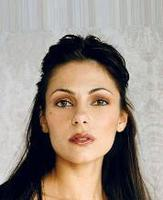


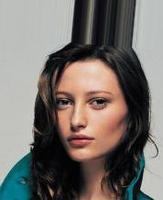


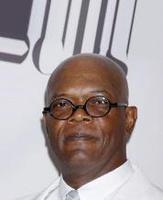


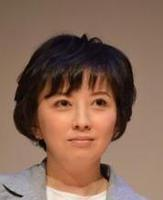


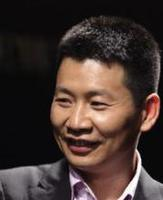


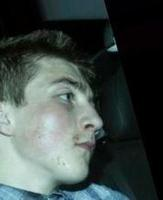


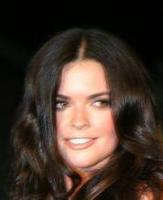


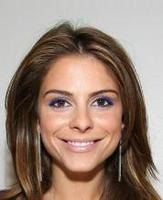

In [45]:
# select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(8)

for index, target in df_to_test.iterrows():
    result = gender_prediction(images_folder + index)
    
    #display result
    display_result(images_folder + index, result[0], target['Male'])